# Imputing Age

In [1]:
#load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

data_dir = 'data/'

data = pd.read_csv(data_dir + 'train.csv')
testdata = pd.read_csv(data_dir + 'test.csv')

data = data.drop('Survived', axis=1)

C:\Users\Pritam Dey\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


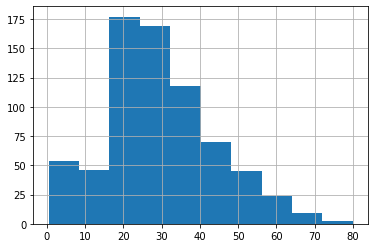

In [3]:
data.Age.hist()

### Note3:
I think number of siblings or parents/children can defintely tell something about the age group of a person. The remaining variables that make a little to no sense are {Pclass, sex, Fare}

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from functon_scripts.CustomEstimators import DropColumns, EmbarkedImputer
from functon_scripts.SpecialImputers import DiscreteVar
from sklearn.preprocessing import OneHotEncoder

cols = data.columns.drop(['Embarked', 'Age', 'Sex', 'Fare'])
fare_bins = [-1, 5, 10, 35, 100, 250, np.inf]
age_bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
clean1 = ColumnTransformer([
    ('drp', DropColumns(drop_ix=[0, 2, 5, 6]), cols),
    ('ohe', OneHotEncoder(), ['Sex']),
    ('dAge', DiscreteVar(bins=age_bins), ['Age']),
    ('dFare', DiscreteVar(bins=fare_bins), ['Fare']),
    ('EmbImp', EmbarkedImputer(), ['Embarked'])
])
# clean1 --

clean_data = clean1.fit_transform(data)

C:\Users\Pritam Dey\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [4]:
Pclass_ix = np.s_[:, 0]
SibSp_ix = np.s_[:, 1]
Parch_ix = np.s_[:, 2]
Sex_ix = np.s_[:, 3:5]
Age_ix = np.s_[:, 5]
Fare_ix = np.s_[:, 6]
Embarked_ix = np.s_[:, 7:10]

clean_data = clean_data[~data.Age.isnull()]
y = clean_data[Age_ix].astype(int)
X = np.c_[clean_data[Pclass_ix], clean_data[Parch_ix],
            clean_data[SibSp_ix], clean_data[Sex_ix], clean_data[Fare_ix]]
X[0:6, :]

array([[3, 0, 1, 0.0, 1.0, 1],
       [1, 0, 1, 1.0, 0.0, 3],
       [3, 0, 0, 1.0, 0.0, 1],
       [1, 0, 1, 1.0, 0.0, 3],
       [3, 0, 0, 0.0, 1.0, 1],
       [1, 0, 0, 0.0, 1.0, 3]], dtype=object)

In [15]:
#train model
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

param_grid = [
    {'n_estimators': np.arange(70, 80, step=2),
     'max_depth': [4, 5, 6],
     'max_leaf_nodes': [3, 4]
    },
]

xgb = XGBClassifier()

grids = GridSearchCV(xgb, param_grid, scoring="f1_macro", return_train_score=True, cv=5)
print(X.shape)
grids.fit(X, y)

joblib.dump(grids.best_estimator_, 'filename.pkl')
grids.best_params_

(714, 5)


{'max_depth': 5, 'max_leaf_nodes': 3, 'n_estimators': 78}

0.23947170113258903


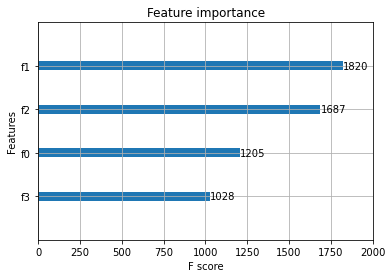

In [16]:
from xgboost import plot_importance

plot_importance(grids.best_estimator_)
print(grids.best_score_)

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

testdata = testdata[~testdata.Age.isnull()]
clean_data = clean1.fit_transform(testdata)

y = clean_data[Age_ix].astype(int)
X = np.c_[clean_data[Pclass_ix], clean_data[Parch_ix],
            clean_data[SibSp_ix], clean_data[Sex_ix]]

y_hat = grids.best_estimator_.predict(X)

plt.imshow(confusion_matrix(y, y_hat), cmap=plt.get_cmap('jet'))
plt.colorbar()

array([-0.22731072, -0.23627792, -0.22221136, -0.22011519, -0.19503342])

-0.2201897205660109


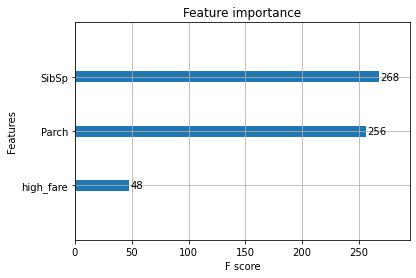

In [8]:
from xgboost import plot_importance

plot_importance(grids.best_estimator_)
print(grids.best_score_)

In [2]:
#create a function to name data frames

namedict = {'Pclass': ['1', '2', '3'], 
            'Sex': ['female', 'male'],
            'Cabin': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'],
            'Embarked': ['C', 'Q', 'S'],
            'Age': '.',
            'SibSp': '.',
            'Parch': '.',
            'Fare': '.',
            }

def col_names(features=[], extra = []):
    namelist = []
    for feature in features:
        for category in namedict[feature]:
            namelist.append(feature + '_' + category)
    namelist.extend(extra)
    return namelist

In [3]:
#load data
Pclass_ix = np.s_[:, 0:3]
Sex_ix = np.s_[:, 3:5]
Cabin_ix = np.s_[:, 5:14]
Embarked_ix = np.s_[:, 14:17]
Age_ix = np.s_[:, 17]
SibSp_ix = np.s_[:, 18]
Parch_ix = np.s_[:, 19]
Fare_ix = np.s_[:, 20]

clean_data = pd.read_csv(data_dir + 'halfclean.csv', index_col=0).to_numpy()

In [16]:
X = np.c_[clean_data[SibSp_ix], clean_data[Parch_ix], clean_data[Fare_ix], clean_data[Sex_ix],
            clean_data[Pclass_ix]]
y = clean_data[Age_ix]

nan_ix = np.isnan(y)
X = X[~nan_ix]
y = y[~nan_ix]

X = pd.DataFrame(X)
X.columns = col_names(features=['SibSp', 'Parch', 'Fare', 'Sex', 'Pclass'])

In [25]:
param_grid = [
    {'n_estimators': np.arange(8,15,step=1), 'max_depth': [2, 3, 4], 'max_leaf_nodes': [4, 5, 6, 7]},
]

grids_xgb_age = GridSearchCV(XGBRegressor(), param_grid, scoring="neg_mean_squared_error", return_train_score=True, cv=5)
grids_xgb_age.fit(X, y)

joblib.dump(grids_xgb_age.best_estimator_, 'xgb_best_age.pkl')
grids_xgb_age.best_params_

{'max_depth': 3, 'max_leaf_nodes': 4, 'n_estimators': 13}

-151.08696331701339


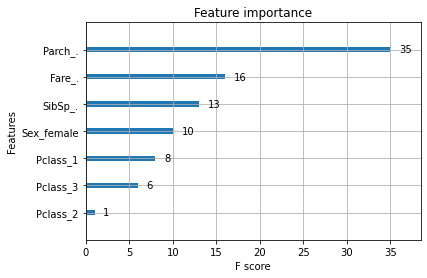

In [26]:
from xgboost import plot_importance

plot_importance(grids_xgb_age.best_estimator_)
print(grids_xgb_age.best_score_)

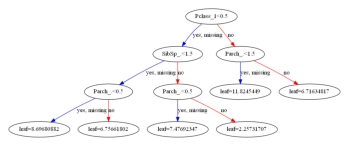

In [29]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_tree(grids_xgb_age.best_estimator_, figsize=(7, 5))